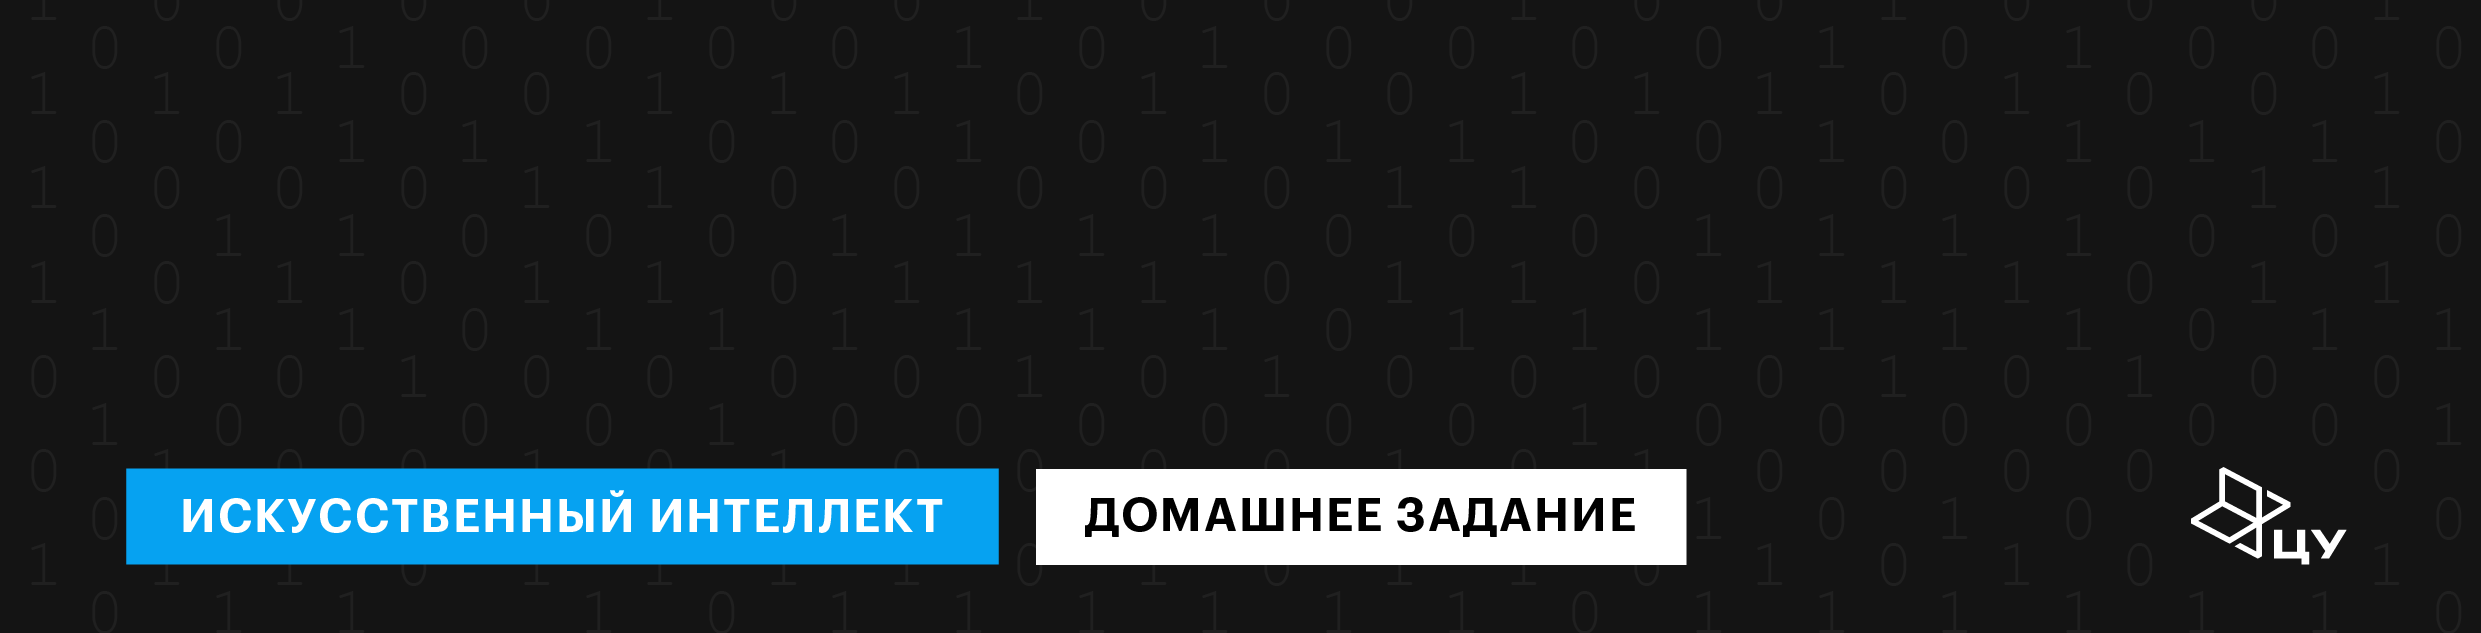

# Домашнее задание по теме «Задачи с изображениями»

В этом задании нужно построить пайплайн обработки изображений, который считает количество определённых объектов на картинке. Для этого подошли бы любые объекты, присутствующие в датасете ImageNet1k — мы выбрали котиков.

## Подготовка

Установим всё необходимое для работы, загрузим картинки с котиками.

[Источник 1](https://crazycatslady.com/what-is-the-limit-for-the-number-of-cats-one-can-have/)

[Источник 2](https://www.alamy.com/)

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

In [ ]:
!gdown https://drive.google.com/uc?id=1bdjSixTeDolWmHh1NKjG6sASwtejTDr5
!gdown https://drive.google.com/uc?id=1_5XZdCWSYohjLECjtLwXtHxQalguSv9q

In [ ]:
import json
!wget -O imagenet_class_index.json https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

with open(f'{HOME}/imagenet_class_index.json', 'r') as f:
    class_idx = json.load(f)
idx_to_class = {int(k): v[1] for k, v in class_idx.items()} # Словарик, который позволяет по номеру класса Imagenet получить название

In [ ]:
!pip install supervision
!pip install hydra-core
!pip install -q iopath
!git clone https://github.com/facebookresearch/sam2.git
%cd {HOME}/sam2
!pip install -e . -q

%cd ..
%cd {HOME}/sam2

In [ ]:
import base64

import numpy as np

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

import torch
import torchvision.transforms as transforms
import torchvision.models as models

assert torch.cuda.is_available()
device = torch.device('cuda')

torch.manual_seed(2025)

In [ ]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Функция для перевода картинки в RGB
def to_rgb(bgr_img):
    rgb_image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    return rgb_image

# Вспомогательная функция для отрисовки результатов сегментации
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Чтобы сделать границы более гладкими
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

In [ ]:
!mkdir -p {HOME}/checkpoints

!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt -P {HOME}/checkpoints

CHECKPOINT = f"{HOME}/checkpoints/sam2.1_hiera_small.pt"
CONFIG = "configs/sam2.1/sam2.1_hiera_s.yaml"

Инициализируем базовую модель SAM2. Чтобы всё работало быстрее, возьмём модель `small`.

In [ ]:
sam2_model = build_sam2(CONFIG, CHECKPOINT, device=device, apply_postprocessing=True)

Иницилизируем обёртку над базовой моделью, которая позволяет автоматически сегментировать объекты на картинке.

In [ ]:
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

In [ ]:
image = to_rgb(cv2.imread(f'{HOME}/cats_photo.jpg'))

In [ ]:
plt.imshow(image)
plt.axis('off');

## Сегментация


### Задача 1 [0,5 балла]

Получи результат обработки `SAM2AutomaticMaskGenerator` по картинке выше. Отрисуй результат, воспользовавшись функцией `show_anns`.

In [ ]:
with torch.autocast("cuda", dtype=torch.bfloat16):
    res = mask_generator.generate(image)
plt.figure(figsize=(8, 10))
plt.imshow(image)
show_anns(res)
plt.axis('off')
plt.show()

## Первая строчка позволяет применить SAM2 с пониженной точностью вычислений, позволяя выиграть в скорости обработки
## Это работает только для определённых моделей, которые к этому были подготовлены
## Не пытайся повторить это с другими моделями, например из torchvision

Посмотри, сколько всего объектов было насегментировано.

In [ ]:
print("Total number of masks: ", len(res))

In [ ]:
plt.figure(figsize=(8, 10))
plt.imshow(image)
show_anns(res)
plt.axis('off')
plt.show()

Не все объекты на картинке отсегментированы. Это можно исправить, поработав с гиперпараметрами генератора масок. Подробнее про гиперпараметры `SAM2AutomaticMaskGenerator` можно почитать [здесь](https://github.com/facebookresearch/sam2/blob/2b90b9f5ceec907a1c18123530e92e794ad901a4/sam2/automatic_mask_generator.py#L59).

In [ ]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    stability_score_thresh=0.92, # Оценка уверенности модели в маске
    stability_score_offset=0.8, # Гиперпараметр для оценки уверенности модели в маске
    box_nms_thresh=0.35, # Максимальный IOU для фильтрации дубликатов
)

> **Примечание.** **IOU** — Intersection Over Union:
>
>$$
IOU = \frac{\text{intersection}(pred \,\, mask, \,target \,\,mask)}{\text{union}(pred \,\, mask,\, target \,\, mask)} \leq 1.
$$
>
> Обычно `IOU` считают как метрику качества классификации: чем она больше, тем точнее модель предсказывает правильные маски. В нашем случае `IOU` используется для фильтрации: модель генерирует много масок, и те, для которых `IOU` больше указанного порога, считаются дубликатами и отфильтровываются.

### Задача 2 [0,5 балла]

Использовав новую версию генератора масок, примени её к картинке и визуализируй результат, как в предыдущей части.

In [ ]:
with torch.autocast("cuda", dtype=torch.bfloat16):
    res = mask_generator_2.generate(image)

In [ ]:
print("Total number of masks: ", len(res))

In [ ]:
plt.figure(figsize=(8, 10))
plt.imshow(image)
show_anns(res)
plt.axis('off')
plt.show()

Убедись, что теперь на картинке отсегментированы все коты.

Это необходимое условие для того, чтобы пайплайн работал.

Здесь можно справедливо заметить, что для разных изображений оптимальные гиперпараметры модели сегментации могут быть разные, и  пайплайн будет плохо обобщаться. Отчасти это правда, но, как будет видно в дальнейшем, с набором выше подход довольно устойчив и неплохо работает.

Полезно будет взглянуть на выход сегментатора.

In [ ]:
res[5]

Сегодня мы будем использовать `segmentation`, бинарную маску сегментации и `bbox` — прямоугольник, который показывает местоположение объекта. Содержимое `bbox` — это $x$-, $y$-координаты левого нижнего угла такого прямоугольника и его длина и ширина соответственно.

> **Примечание.** Чтобы не грузить тяжёлую модель SAM2 каждый раз, когда перезагружается Colab, рекомендуем сохранить результаты на диск и потом загрузить их с диска.

In [ ]:
import pickle

def save_sam2_output(sam2_outputs, path):
    with open(path, 'wb') as f:
        pickle.dump(sam2_outputs, f)

def load_sam2_output(path):
    with open(path, 'rb') as file:
        loaded_data = pickle.load(file)
    return loaded_data


In [ ]:
save_sam2_output(res, f'{HOME}/res.pkl')


In [ ]:
res = load_sam2_output(f'{HOME}/res.pkl')

## Классификация. Наивный подход

Модель `SAM2` при всех своих преимуществах не умеет самостоятельно определять, что за объекты она сегментирует. При этом задача — посчитать количество котов на картинке. Естественно, на картинке отсегментированы не только коты. Как же быть?

Вспомним о моделях классификации, которые рассматривались на семинаре. Их особенность в том, что они не умеют определять количество объектов и только показывают, есть объект определенного класса на картинке или нет.

Используем сильные стороны моделей (SAM2 и модели классификации), чтобы решить задачу.


Как уже было сказано, в каждом результате SAM2 есть `bounding box` сегментированного объекта. Теоретически его можно использовать, чтобы кропнуть (от англ. crop, «обрезать») изначальную картинку, оставив в ней только один этот объект. Тогда для каждого такого кропа можно прогнать модель классификации и понять, есть на кропе нужный объект (в нашем случае кот) или нет.

In [ ]:
def init_model(device):
    model = models.resnet50(weights='IMAGENET1K_V1')
    model.to(device)
    for param in model.parameters():
       param.requires_grad_(False)
    model.eval();
    return model

model = init_model(device)

Можно сразу инициализировать классификатор, который будет использоваться в дальнейшем. Остановимся на модели `resnet50` из библиотеки `torchvision`, предобученной на `ImageNet1k`.

Выделим один объект, на котором обкатаем подход.

In [ ]:
test_res = res[8]

### Задача 3 [4 балла]


 Выполни пункты ниже **[1 балл]**:

1. Реализуй функцию `get_bbox_image_crop`.
2. Ипользуй её, чтобы выделить область изображения (далее **кроп**), соответствующую `bbox` этого объекта.
3. Отрисуй результат.

In [ ]:
def get_bbox_image_crop(image, sam2_output):
    image_crop = Image.fromarray(image).crop((sam2_output['bbox'][0], sam2_output['bbox'][1], sam2_output['bbox'][0] + sam2_output['bbox'][2], sam2_output['bbox'][1] + sam2_output['bbox'][3]))
    return np.array(image_crop)

In [ ]:
image_crop = get_bbox_image_crop(image, test_res)
plt.imshow(image_crop)

In [ ]:
assert image_crop.shape[0] == test_res['bbox'][3]
assert image_crop.shape[1] == test_res['bbox'][2]

Известно, что модели типа `resnet` работают с входами 224 × 224. Значит, нужно соответствующим образом подготовить кропы, прежде чем передавать их в классификатор.

Если размер кропа меньше требуемого, можно просто добавить нулей по краям. Такая техника называется **падинг**.

Реализуй функцию `pad_image_crop`. **[0,5 балла]**



In [ ]:
def pad_image_crop(image_crop):
    image = Image.fromarray(image_crop)
    padded_image = Image.new("RGB", (224, 224), (0, 0, 0))
    offset = ((224 - image.width) // 2, (224 - image.height) // 2)
    padded_image.paste(image, offset)
    padded_image_crop = np.array(padded_image)
    return np.array(padded_image_crop)


In [ ]:
image_crop = pad_image_crop(image_crop)

assert image_crop.shape == (224, 224, 3)
assert np.sum((image_crop[0:2, 0:2, :], image_crop[0:2, -2:, :], image_crop[-2:, 0:2, :], image_crop[-2:, -2:, :])) == 0

In [ ]:
plt.imshow(image_crop)

Также может получиться, что кроп будет больше, чем 224 × 224.

В этом случае нужно сделать `resize` с помощью библиотеки `torchvision.transforms` и добавить нормализацию (подробнее о том, зачем она нужна, в семинаре).

Заполни пропуски в функции `transform_crop`. **[0,5 балла]**

In [ ]:
def transform_crop(image_crop):
    resize_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    norm_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    transformed_crop = resize_transform(image_crop)
    return transformed_crop

In [ ]:
tensor_crop = transform_crop(image_crop)

In [ ]:
plt.imshow(tensor_crop.numpy().transpose(1, 2, 0))

Теперь всё готово к тому, чтобы с помощью классификатора понять, что же изображено на картинке.

In [ ]:
tensor_crop = tensor_crop.to(device)

with torch.no_grad():
    logits = model(tensor_crop.unsqueeze(0)) # Не забываем, что нужно добавить размерность батчей в картинку

probabilities = torch.nn.functional.softmax(logits, dim=1) # Считаем вероятности
probs, preds = torch.topk(probabilities, k=3) # Оставляем k самых вероятных классов
for pred in preds[0]:
    class_name = idx_to_class[pred.item()]
    prob = probabilities[0, pred.item()].item()
    print(f"{class_name}: {prob*100:.2f}%")

Модель правильно определила, что на картинке есть кот.

Можно заметить, что все три самых вероятных класса, по мнению модели, это какие-то виды котов. Для решения заадчи важно только, что это кот, а значит, подойдёт любой из классов выше. Объединим все «кошачьи» классы из `ImageNet` в один.

In [ ]:
CAT_CLASSES = [281, 282, 283, 284, 285, 383]

for cat_class in CAT_CLASSES:
    print(idx_to_class[cat_class], end = ' ')

Напиши функцию `get_cat_score`, которая будет принимать на вход вероятности каждого класса и выводить вероятность того, что на картинке изображён один из «кошачьих» классов. Обращаем внимание, функция должна корректно работать также в случае, где `batch_size > 1`. **[1 балл]**

In [ ]:
def get_cat_score(probabilities):
  cat_probs = probabilities[:, CAT_CLASSES]
  cat_score = cat_probs.sum(dim=1)
  return cat_score

assert get_cat_score(probabilities).shape[0] == probabilities.shape[0]

In [ ]:
print(get_cat_score(probabilities))

Замечательно! Осталось прогнать классификатор по всем выходам сегментатора. Можно было бы прогнать классификатор циклом по одному выходу, но в реальной задаче это почти всегда долго и неправильно. Вместо этого нужно использовать возможность обрабатывать объекты параллельно, батчами, которую предоставляет GPU. Для этого необходимо создать нужный `Dataset` и `DataLoader`.

Заполни пропуски в функции `prepare_bbox_tensor` и классе `BboxDataset`. **[1 балл]**

In [ ]:
from torch.utils.data import Dataset, DataLoader

def prepare_bbox_tensor(original_image, sam2_output):
    crop = get_bbox_image_crop(original_image, sam2_output)
    padded = pad_image_crop(crop)
    return transform_crop(padded)


class BboxDataset(Dataset):
    def __init__(self, original_image, sam2_outputs):
        self.original_image = original_image
        self.sam2_outputs = sam2_outputs

    def __len__(self):
         return len(self.sam2_outputs)

    def __getitem__(self, idx):
        sam2_output = self.sam2_outputs[idx]
        bbox_tensor = prepare_bbox_tensor(self.original_image, sam2_output)
        return bbox_tensor


In [ ]:
bbox_dataset = BboxDataset(image, res)

assert np.allclose(
    bbox_dataset[8],
    tensor_crop.cpu().numpy()
)

In [ ]:
plt.imshow(bbox_dataset[8].numpy().transpose(1, 2, 0))

В получившемся датасете не очень много элементов, поэтому их, скорее всего, можно обработать за один батч.

In [ ]:
bbox_dataloader = DataLoader(bbox_dataset, batch_size=len(bbox_dataset), shuffle=False)

Определим вспомогательную функцию.

In [ ]:
def get_probabilities(model, tensor, device):
    if len(tensor.shape) == 3:
        tensor = tensor.unsqueeze(0) # Если нужно, добавляем размерность `batch_size`
    tensor = tensor.to(device)
    with torch.no_grad():
        logits = model(tensor)
    # Считаем вероятности всех классов для всех объектов батча
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    return probabilities

In [ ]:
total_cat_number = 0

for batch in bbox_dataloader:
    probabilities = get_probabilities(model, batch, device) # shape (batch_size, 1000)
    # Считаем вероятность того, что на объекте изображён кот, для всех объектов батча
    cat_scores = get_cat_score(probabilities) # shape (batch_size, 1)
    # Смотрим самый вероятный класс для всех объектов батча
    prob, pred = torch.topk(probabilities, k=1)
    # prob.shape == pred.shape == (batch_size, 1)
    # Если вероятность кота больше top-1 вероятности из всех классов, то кот на картинке есть
    # Если меньше, то кота нет
    # Делаем так для каждого элемента батча
    is_cat = cat_scores.flatten() > prob.flatten()
    total_cat_number += torch.sum(is_cat)

print(total_cat_number.item())

Ура!

Стоп, но ведь котов на картинке всего 4.

In [ ]:
plt.figure(figsize=(8, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

Вероятно, что-то сделано не так. Попробуем определить проблему и справиться с ней.

## Классификация. Улучшенный подход

Предыдущий подход не зря назван наивным. Если взять `bbox` какого-то объекта, то в него могут попадать другие, соседние объекты. Проиллюстрируем это на примере `res[0]`.

In [ ]:
test_res = res[0]

In [ ]:
image_crop = get_bbox_image_crop(image, test_res)
plt.imshow(image_crop)

Объект в данном случае — это стенка за спиной у котёнка. Однако котёнок попадает на `bbox` стенки, а значит, его видит классификатор. Это приводит к тому, что классификатор определяет объект «стенка» как кота.

### Задача 4  [5 баллов]

Выведи `cat_score` данного кропа. **[0,5 балла]**

In [ ]:
tensor_crop = transform_crop(image_crop)
probabilities = get_probabilities(model, tensor_crop, device)
print(get_cat_score(probabilities))

Видно, что кот есть на картинке с достаточно высокой вероятностью.

Теперь вырежем из кропа оригинальной картинки всё, что не попадает в маску сегментации соответствующего объекта. В этом случае лишние объекты не будут попадать на кроп, и классификатор (в теории) не ошибётся.

Посмотрим, что представляет из себя маска сегментации.

In [ ]:
print(test_res['bbox'])
plt.imshow(test_res['segmentation'], cmap='grey')

In [ ]:
print(test_res['segmentation'])
test_res['segmentation'].shape

На картинке нужно оставить только те объекты, которые попадают в маску сегментации. **[0,5 балла]**

In [ ]:
seg_mask = test_res['segmentation'].astype(np.uint8)

seg_image = image.copy()
seg_image[seg_mask==0] = 0

plt.imshow(seg_image)

Чтобы результаты получились устойчивей, нужно увеличить сегментационную маску в размере. Она всё ещё не должна захватывать другие объекты, но с меньшей вероятностью будет обрезать релевантную информацию. Для этого воспользуйся функцией `cv2.dilate`. **[1 балл]**

In [ ]:
kernel = np.ones((25, 25))
seg_mask = test_res['segmentation'].astype(np.uint8)


seg_image = image.copy()
dilated_mask = cv2.dilate(seg_mask, kernel, iterations=1, borderType=cv2.BORDER_CONSTANT, borderValue=0)

seg_image[dilated_mask == 0] = 0

plt.imshow(seg_image);

Закончи реализацию `get_seg_image_crop`. **[2 балла]**

In [ ]:
def get_seg_image_crop(image, sam2_output):
    seg_mask = sam2_output['segmentation'].astype(np.uint8)
    kernel = np.ones((25, 25))
    # 1. Увеличить маску с помощью cv2.dilate
    seg_image = image.copy()
    dilated_mask = cv2.dilate(seg_mask, kernel, iterations=1, borderType=cv2.BORDER_CONSTANT, borderValue=0)
    # 2. Занулить все пиксели картинки, не входящие в маску

    seg_image[dilated_mask == 0] = 0


    # 3. Получить новый bbox, который полностью включает в себя увеличенную маску

    seg_image_crop = get_bbox_image_crop(seg_image, sam2_output)
    return seg_image_crop


def prepare_seg_tensor(original_image, sam2_output):
    image_crop = get_seg_image_crop(original_image, sam2_output)

    padded_image_crop = pad_image_crop(image_crop)

    tensor_crop = transform_crop(padded_image_crop)
    return tensor_crop

Прогони классификатор на получившемся кропе. Выведи `cat_score`. **[0,5 балла]**

In [ ]:
probabilities = get_probabilities(model, prepare_seg_tensor(image, test_res), device)
cat_score = get_cat_score(probabilities)

In [ ]:
assert cat_score.item() < 0.1

Теперь гораздо лучше. Классификатор не находит на картинке кота.

Осталось внести новый функционал в класс `SegDataset` и получить результат (точное число котов на картинке).

Внеси функционал в новый `Dataset`. **[0,5 балла]**

In [ ]:
class SegDataset(Dataset):
    def __init__(self, original_image, sam2_outputs):
        self.original_image = original_image
        self.sam2_outputs = sam2_outputs

    def __len__(self):
         return len(self.sam2_outputs)

    def __getitem__(self, idx):
        sam2_output = self.sam2_outputs[idx]
        seg_tensor = prepare_seg_tensor(self.original_image, sam2_output)
        return seg_tensor

Получим результат.

In [ ]:
seg_dataset = SegDataset(image, res)
seg_dataloader = DataLoader(seg_dataset, batch_size=len(seg_dataset), shuffle=False)

In [ ]:
total_cat_number = 0

for batch in seg_dataloader:
    probabilities = get_probabilities(model, batch, device) # shape (batch_size, 1000)
    # Считаем вероятность, что на объекте изображён кот, для всех объектов батча
    cat_scores = get_cat_score(probabilities) # shape (batch_size, 1)
    # Смотрим самый вероятный класс для всех объектов батча
    prob, pred = torch.topk(probabilities, k=1)
    # prob.shape == pred.shape == (batch_size, 1)
    # Если вероятность кота больше top-1 вероятности из всех классов, то кот на картинке есть
    # Если меньше, то кота нет
    # Делаем так для каждого элемента батча
    is_cat = cat_scores.flatten() > prob.flatten()
    total_cat_number += torch.sum(is_cat)

In [ ]:
if total_cat_number.item() == 4:
    print('Отличная работа!')
else:
    print(':(')

## Дополнительное задание

In [ ]:
new_image = to_rgb(cv2.imread(f'{HOME}/cats_apples.png'))

In [ ]:
plt.figure(figsize=(8, 10))
plt.imshow(new_image)
plt.show()

In [ ]:
with torch.autocast("cuda", dtype=torch.bfloat16):
    res_2 = mask_generator_2.generate(new_image)

In [ ]:
save_sam2_output(res_2, f'{HOME}/res_2.pkl')
res_2 = load_sam2_output(f'{HOME}/res_2.pkl')

In [ ]:
new_dataset = SegDataset(new_image, res_2)
new_dataloader = DataLoader(new_dataset, batch_size=32, shuffle=False)